In [82]:
from bs4 import BeautifulSoup as bs
from sklearn.externals.joblib import Memory
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import csv
from matplotlib.ticker import MultipleLocator
from pandas.plotting import table 
%matplotlib inline

In [3]:
memory = Memory(location='/mnt/c/Users/Jamie/Desktop/UDEMY/personal/shootscore/mem', verbose=0)

In [4]:
@memory.cache
def get_player_shots(sluglist, year):
    playershots = []
    for i, person in enumerate(sluglist):
        personshooting = requests.get("https://www.basketball-reference.com/play-index/shooting.fcgi?player_id=" + person + "&year_id=" + str(year) + "&is_playoffs=0")
        parsed_personshooting = bs(personshooting.content, "html.parser")
        titlewords = parsed_personshooting.find("title")
        if titlewords:            
            titlewords = titlewords.get_text().split()
            playername = str(titlewords[0] + " " + titlewords[1])
            shot_distances_all = parsed_personshooting.find_all("tr")
            shooting_indices = []
            for j, row in enumerate(shot_distances_all):
                strrow = str(row)
                if "Shot Distance" in strrow or "Shot Type" in strrow:
                    shooting_indices.append(j)
            shootersplits = [playername, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
            if(len(shooting_indices) ==  2):
                shot_distances = shot_distances_all[shooting_indices[0]:shooting_indices[1] - 1]
                for shot in shot_distances:
                    shot_curdist = shot.find_all("td")
                    strshot_curdist = str(shot_curdist)
                    if "At Rim" in strshot_curdist:
                        shootersplits[1] = int(shot_curdist[1].get_text())
                        shootersplits[2] = int(shot_curdist[2].get_text())
                    elif "3 to &lt;10 ft" in strshot_curdist:
                        shootersplits[3] = int(shot_curdist[1].get_text())
                        shootersplits[4] = int(shot_curdist[2].get_text())
                    elif "10 to &lt;16 ft" in strshot_curdist:
                        shootersplits[5] = int(shot_curdist[1].get_text())
                        shootersplits[6] = int(shot_curdist[2].get_text())
                    elif "16 ft to &lt;3-pt" in strshot_curdist:
                        shootersplits[7] = int(shot_curdist[1].get_text())
                        shootersplits[8] = int(shot_curdist[2].get_text())
                    elif "3-pt" in strshot_curdist:
                        shootersplits[9] = int(shot_curdist[1].get_text())
                        shootersplits[10] = int(shot_curdist[2].get_text())
                playershots.append(shootersplits)
    return playershots

In [5]:
@memory.cache
def create_shooting_dataframe(raw_playershots):
    np_playershots = np.array(raw_playershots)
    playershots = pd.DataFrame({"Player Name":np_playershots[:,0], "At Rim Makes":np_playershots[:,1], 
                                "At Rim Attempts":np_playershots[:,2], "3 To 10 Feet Makes":np_playershots[:,3], 
                                "3 To 10 Feet Attempts":np_playershots[:,4], "10 To 16 Feet Makes":np_playershots[:,5],
                                "10 To 16 Feet Attempts":np_playershots[:,6], "16 Feet To 3-Pt Makes":np_playershots[:,7], 
                                "16 Feet To 3-Pt Attempts":np_playershots[:,8], "3-Pt Makes":np_playershots[:,9], 
                                "3-Pt Attempts":np_playershots[:,10]})
    
    playershots = playershots.set_index("Player Name")
    playershots = playershots.drop_duplicates()
    
    playershots["At Rim Makes"] = playershots["At Rim Makes"].apply(int)
    playershots["At Rim Attempts"] = playershots["At Rim Attempts"].apply(int)
    playershots["3 To 10 Feet Makes"] = playershots["3 To 10 Feet Makes"].apply(int)
    playershots["3 To 10 Feet Attempts"] = playershots["3 To 10 Feet Attempts"].apply(int)
    playershots["10 To 16 Feet Makes"] = playershots["10 To 16 Feet Makes"].apply(int)
    playershots["10 To 16 Feet Attempts"] = playershots["10 To 16 Feet Attempts"].apply(int)
    playershots["16 Feet To 3-Pt Makes"] = playershots["16 Feet To 3-Pt Makes"].apply(int)
    playershots["16 Feet To 3-Pt Attempts"] = playershots["16 Feet To 3-Pt Attempts"].apply(int)
    playershots["3-Pt Makes"] = playershots["3-Pt Makes"].apply(int)
    playershots["3-Pt Attempts"] = playershots["3-Pt Attempts"].apply(int)
    
    return playershots

In [6]:
@memory.cache
def get_shot_totals(playershots):
    shot_totals = [playershots["At Rim Makes"].sum(), playershots["At Rim Attempts"].sum(),
        playershots["3 To 10 Feet Makes"].sum(), playershots["3 To 10 Feet Attempts"].sum(),
        playershots["10 To 16 Feet Makes"].sum(), playershots["10 To 16 Feet Attempts"].sum(),
        playershots["16 Feet To 3-Pt Makes"].sum(), playershots["16 Feet To 3-Pt Attempts"].sum(),
        playershots["3-Pt Makes"].sum(), playershots["3-Pt Attempts"].sum()]
    return shot_totals

In [7]:
@memory.cache
def get_shot_averages(shot_totals):
    shot_averages = [float(shot_totals[0]) / float(shot_totals[1]), 
                float(shot_totals[2]) / float(shot_totals[3]),
                float(shot_totals[4]) / float(shot_totals[5]),
                float(shot_totals[6]) / float(shot_totals[7]),
                float(shot_totals[8]) / float(shot_totals[9])]
    return shot_averages

In [8]:
@memory.cache
def create_shootscore(playershots, shot_averages):
    playershots["Shootscore"] = 0
    
    #playershots["Shootscore"] += (2 * playershots["At Rim Makes"] * (1 - shot_averages[0])**2)
    playershots["Shootscore"] += (2 * playershots["3 To 10 Feet Makes"] * (1 - shot_averages[1])**2)
    playershots["Shootscore"] += (2 * playershots["10 To 16 Feet Makes"] * (1 - shot_averages[2])**2)
    playershots["Shootscore"] += (2 * playershots["16 Feet To 3-Pt Makes"] * (1 - shot_averages[3])**2)
    playershots["Shootscore"] += (3 * playershots["3-Pt Makes"] * (1 - shot_averages[4])**2)

    #playershots["Shootscore"] -= (2 * (playershots["At Rim Attempts"] - playershots["At Rim Makes"]) * (shot_averages[0])**2)
    playershots["Shootscore"] -= (2 * (playershots["3 To 10 Feet Attempts"] - playershots["3 To 10 Feet Makes"])* (shot_averages[1])**2)
    playershots["Shootscore"] -= (2 * (playershots["10 To 16 Feet Attempts"] - playershots["10 To 16 Feet Makes"]) * (shot_averages[2])**2)
    playershots["Shootscore"] -= (2 * (playershots["16 Feet To 3-Pt Attempts"] - playershots["16 Feet To 3-Pt Makes"]) * (shot_averages[3])**2)
    playershots["Shootscore"] -= (3 * (playershots["3-Pt Attempts"] - playershots["3-Pt Makes"]) * (shot_averages[4])**2)
    
    return playershots

In [9]:
@memory.cache
def sort_by_shootscore(playershots):
    playershots = playershots.sort_values("Shootscore", ascending = False)
    return playershots

In [10]:
@memory.cache
def sort_by_shootscore_index(playershots):
    playershots = playershots.sort_values("Shootscore Index", ascending = False)
    return playershots

In [11]:
raw_playershots_list = []
@memory.cache
def fill_raw_playershots_list():
    for i in range (2000, 2018):
        with open("playersluglist" + str(i) + str(i + 1) +".txt", "r") as slugs:
            slug = slugs.read().replace("\n", " ")
            sluglist = slug.split(" ")
            raw_playershots_list.append(get_player_shots(sluglist, i + 1)) 
fill_raw_playershots_list()

In [12]:
playershots_list = []
for raw_playershots in raw_playershots_list:
    playershots = create_shooting_dataframe(raw_playershots)
    shot_totals = get_shot_totals(playershots)
    shot_averages = get_shot_averages(shot_totals)
    playershots = create_shootscore(playershots, shot_averages)
    playershots_list.append(playershots)

playershootscores_list = []
for playershots in playershots_list:
    playershootscores = sort_by_shootscore(playershots.drop(columns = ["At Rim Makes", "At Rim Attempts",
                                                              "3 To 10 Feet Makes", "3 To 10 Feet Attempts",
                                                              "10 To 16 Feet Makes", "10 To 16 Feet Attempts",
                                                              "16 Feet To 3-Pt Makes", "16 Feet To 3-Pt Attempts",
                                                              "3-Pt Makes", "3-Pt Attempts"]))
    playershootscores_list.append(playershootscores)

playershootscores_comprehensivelist = []
for i, playershootscores in enumerate(playershootscores_list):
    playershootscores["Year"] = str(i + 2001)
    playershootscores_comprehensivelist.append(playershootscores)

In [15]:
shootscores_totals_means_stds = {"Shootscore Year": [], "Shootscore Total": [], "Shootscore Mean": [], "Shootscore STD": []}
for i in range (2001, 2019):
    shootscores_totals_means_stds["Shootscore Year"].append(i)
    current_shootscores_year = playershootscores_comprehensivelist[i - 2001]["Shootscore"]
    shootscores_totals_means_stds["Shootscore Total"].append(current_shootscores_year.size)
    shootscores_totals_means_stds["Shootscore Mean"].append(current_shootscores_year.mean())
    shootscores_totals_means_stds["Shootscore STD"].append(current_shootscores_year.std());
shootscores_totals_means_stds_df = pd.DataFrame(shootscores_totals_means_stds)
shootscores_totals_means_stds_df["Shootscore Year"] = shootscores_totals_means_stds_df["Shootscore Year"].apply(str)

In [16]:
@memory.cache
def get_shootscore_index(shootscore_year, shootscore):
    shootscore_meanandstd_year = shootscores_totals_means_stds_df[shootscores_totals_means_stds_df["Shootscore Year"] == shootscore_year]
    shootscore_std = (shootscore - shootscore_meanandstd_year["Shootscore Mean"]) / shootscore_meanandstd_year["Shootscore STD"]
    return float(shootscore_std)

In [20]:
for i in range(0, 18):
    playershootscores_comprehensivelist[i]["Shootscore Index"] = playershootscores_comprehensivelist[i].apply(lambda row: get_shootscore_index(row["Year"], row["Shootscore"]), axis = 1)
    
playershootscores_comprehensive_1 = playershootscores_comprehensivelist[0]
playershootscores_comprehensive_2 = playershootscores_comprehensivelist[10]

for i in range (1, 9):
    playershootscores_comprehensive_1 = playershootscores_comprehensive_1.append(playershootscores_comprehensivelist[i])
for i in range (11, 18):
    playershootscores_comprehensive_2 = playershootscores_comprehensive_2.append(playershootscores_comprehensivelist[i])

playershootscores_comprehensive_1 = sort_by_shootscore(playershootscores_comprehensive_1)
playershootscores_comprehensive_2 = sort_by_shootscore(playershootscores_comprehensive_2)
playershootscores_comprehensive = sort_by_shootscore(playershootscores_comprehensive_1.append(playershootscores_comprehensive_2))

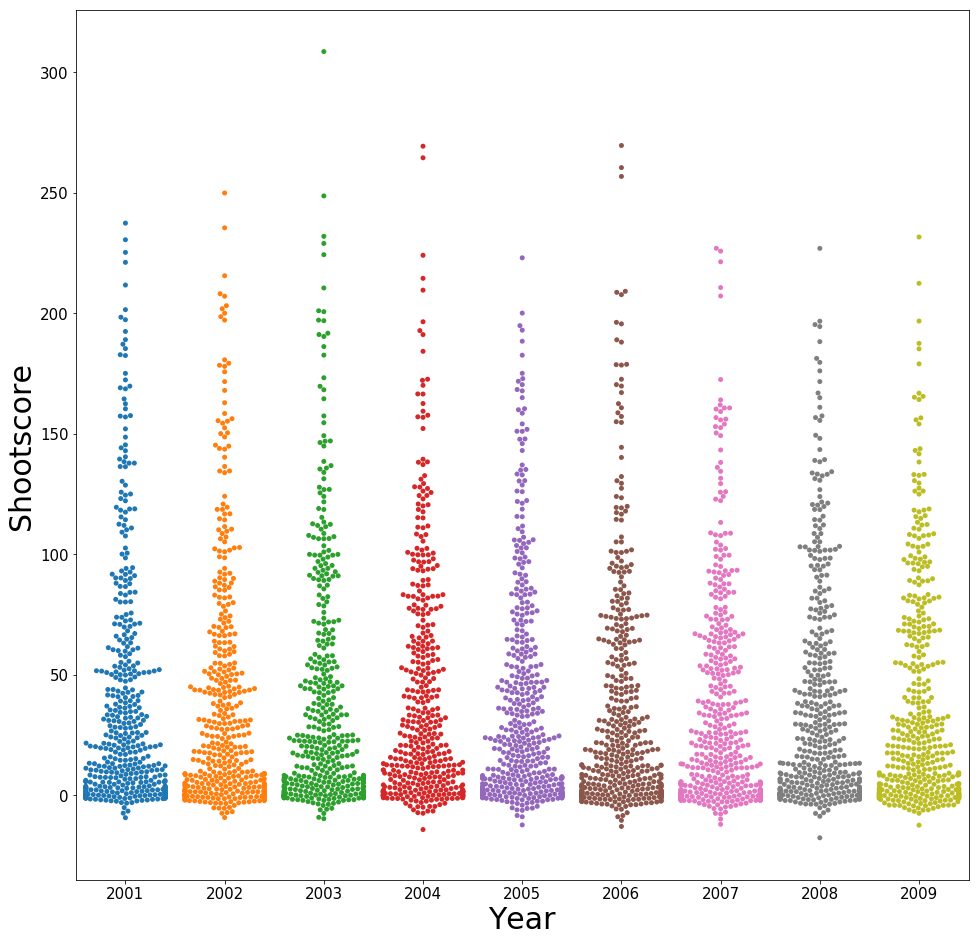

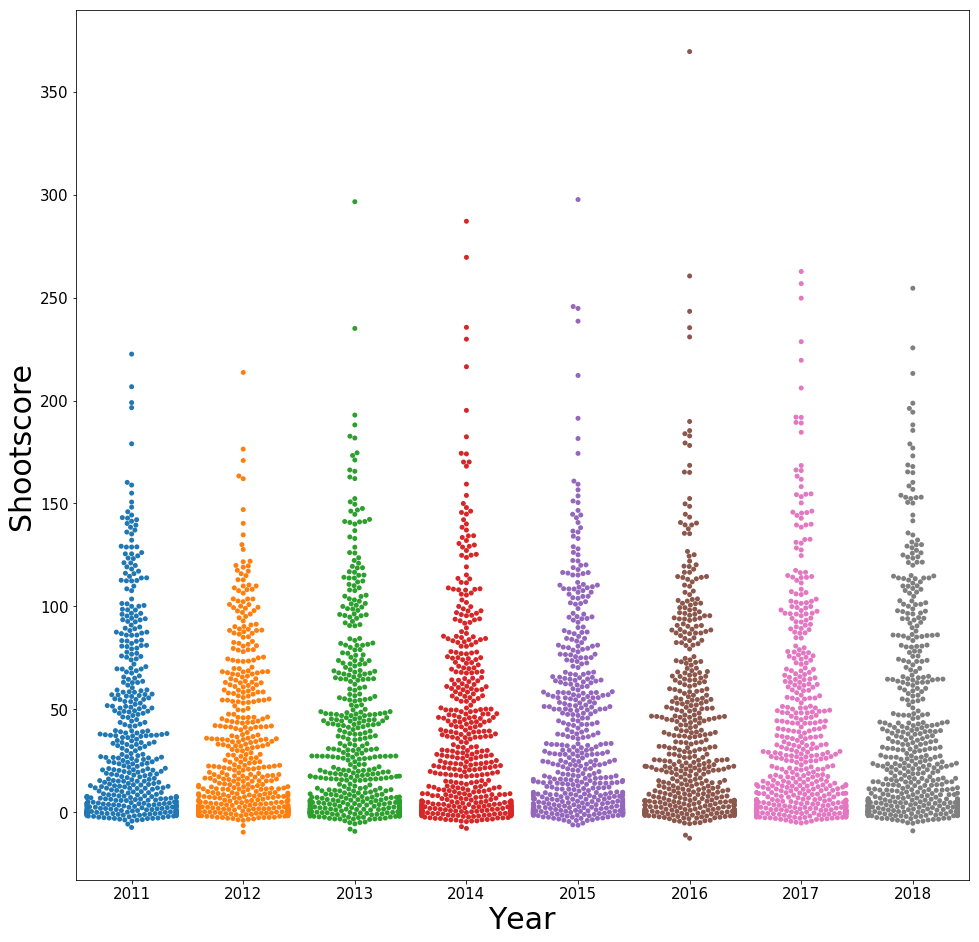

In [21]:
graph1_dims = (16, 16)
fig, ax = plt.subplots(figsize = graph1_dims)
graph1 = sns.swarmplot(ax = ax, x= playershootscores_comprehensive_1["Year"], y = playershootscores_comprehensive_1["Shootscore"])
graph1.set_xlabel("Year",fontsize=30)
graph1.set_ylabel("Shootscore",fontsize=30)
graph1.tick_params(labelsize = 15)

graph2_dims = (16, 16)
fig, ax = plt.subplots(figsize = graph2_dims)
graph2 = sns.swarmplot(ax = ax, x= playershootscores_comprehensive_2["Year"], y = playershootscores_comprehensive_2["Shootscore"])
graph2.set_xlabel("Year",fontsize=30)
graph2.set_ylabel("Shootscore",fontsize=30)
graph2.tick_params(labelsize = 15)

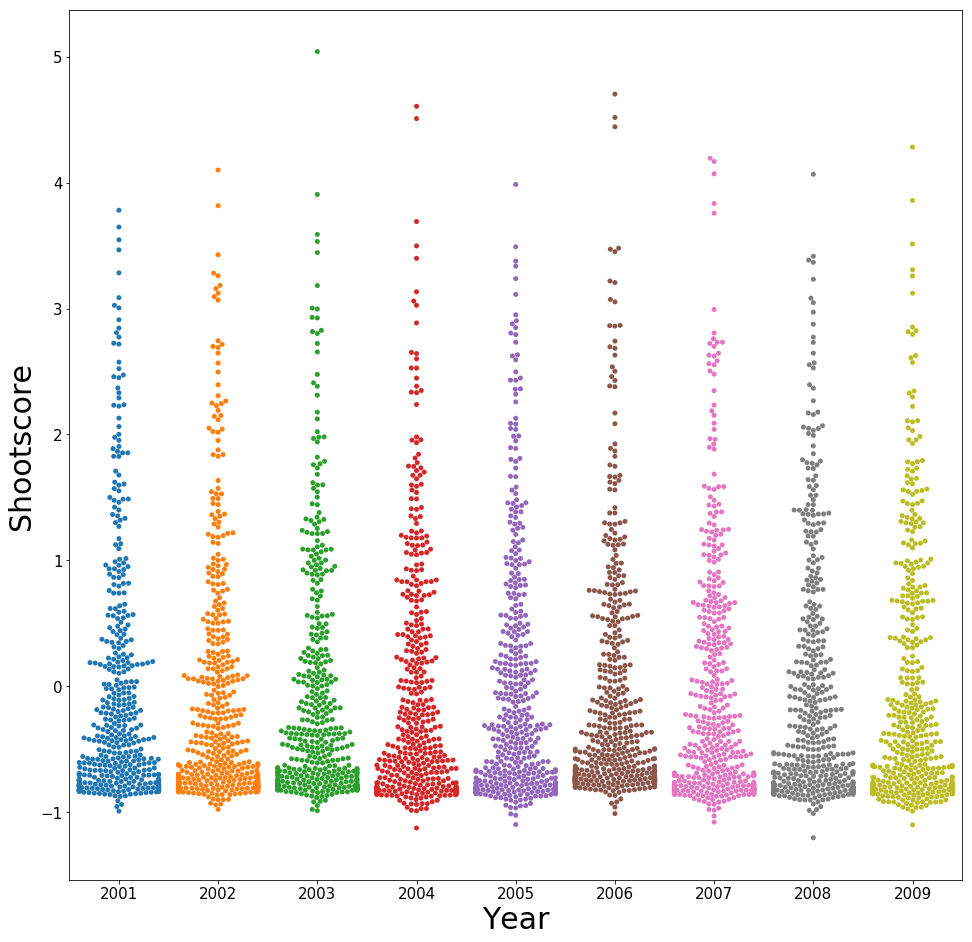

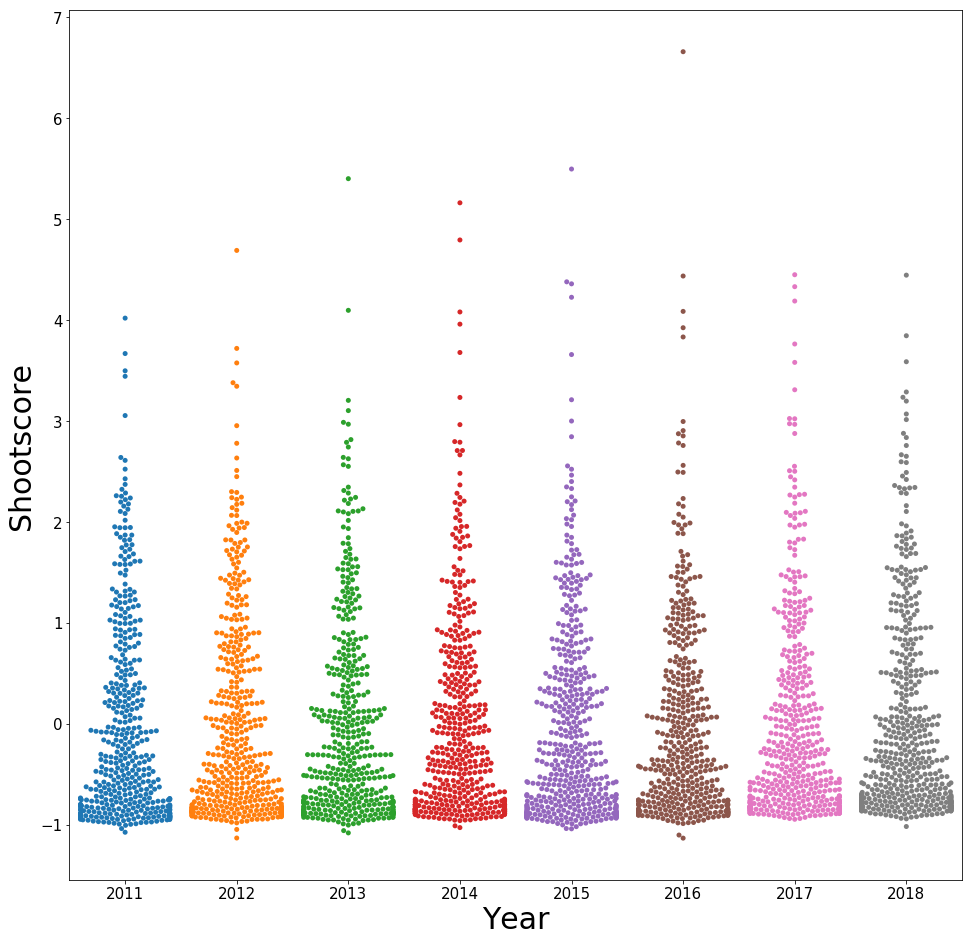

In [92]:
graph3_dims = (16, 16)
fig, ax = plt.subplots(figsize = graph3_dims)
graph3 = sns.swarmplot(ax = ax, x= playershootscores_comprehensive_1["Year"], y = playershootscores_comprehensive_1["Shootscore Index"])
graph3.set_xlabel("Year",fontsize=30)
graph3.set_ylabel("Shootscore",fontsize=30)
graph3.tick_params(labelsize = 15)
plt.savefig("Shootscore distribution 2001-2010.png")

graph4_dims = (16, 16)
fig, ax = plt.subplots(figsize = graph4_dims)
graph4 = sns.swarmplot(ax = ax, x= playershootscores_comprehensive_2["Year"], y = playershootscores_comprehensive_2["Shootscore Index"])
graph4.set_xlabel("Year",fontsize=30)
graph4.set_ylabel("Shootscore",fontsize=30)
graph4.tick_params(labelsize = 15)
plt.savefig("Shootscore distribution 2011-2018.png")

In [23]:
playershootscores_sum = sort_by_shootscore(playershootscores_comprehensive.groupby(playershootscores_comprehensive.index).sum())
playershootscore_indexs_sum = sort_by_shootscore_index(playershootscores_sum)
playershootscores_mean = sort_by_shootscore(playershootscores_comprehensive.groupby(playershootscores_comprehensive.index).mean())
playershootscore_indexs_mean = sort_by_shootscore_index(playershootscores_comprehensive.groupby(playershootscores_comprehensive.index).mean())

In [50]:
max_players = max(shootscores_totals_means_stds["Shootscore Total"])
def player_shootscore_ranks_graph(name):
    player_shootscore_ranks_by_year = []
    for i in range(0, 19):
        try:
            year = i + 2001
            player_shootscore_rank = np.where(playershootscores_comprehensivelist[i].index == name)[0][0] + 1
            player_shootscore_ranks_by_year.append((year, player_shootscore_rank))
        except:
            pass
    
    x, y = zip(*player_shootscore_ranks_by_year)
    plt.figure(figsize=(12, 6))
    graph = sns.lineplot(x, y)
    graph.set_title(name + " Shootscore ranking by year", fontsize = 30)
    
    graph.xaxis.set_major_locator(MultipleLocator(1))
    graph.yaxis.set_major_locator(MultipleLocator(50))
    
    graph.set_xlabel("Year",fontsize=20)
    graph.set_ylabel("Shootscore Rank",fontsize=20)    
    graph.set_xlim(2001, 2018)
    graph.set_ylim(1, max_players)
    
    graph.tick_params(labelsize = 10)
    graph.invert_yaxis()
    


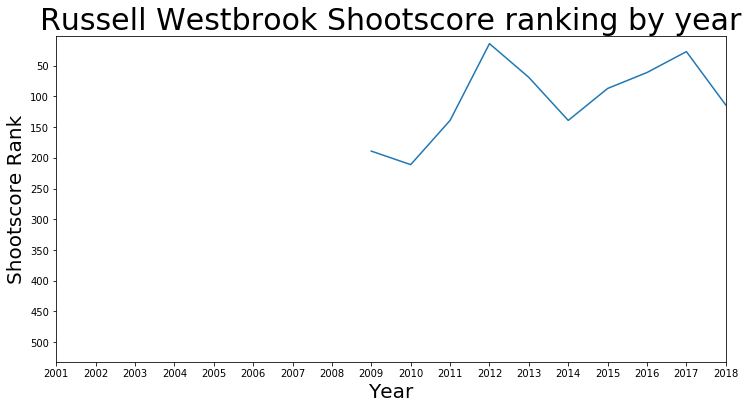

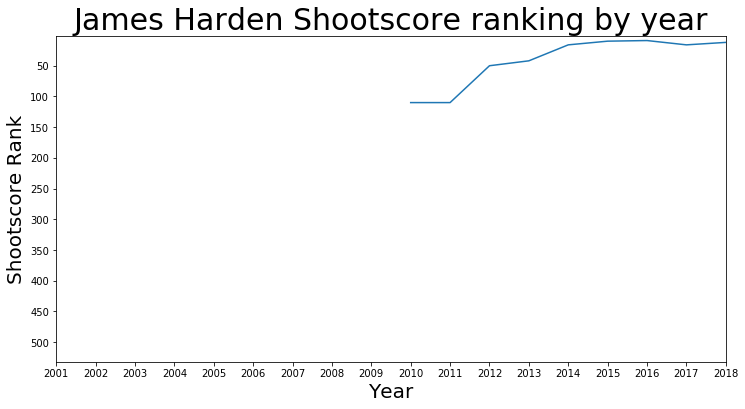

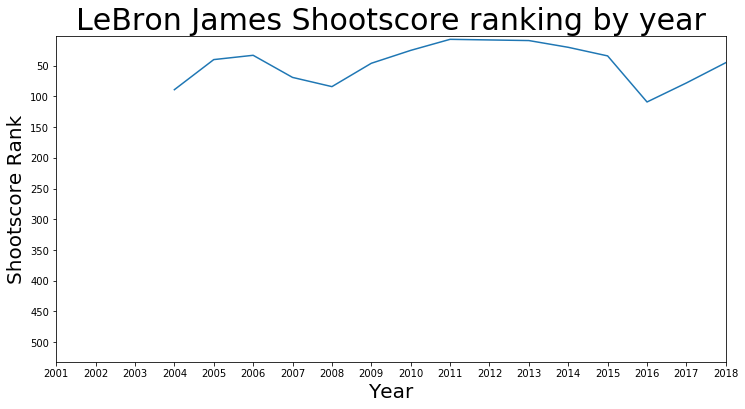

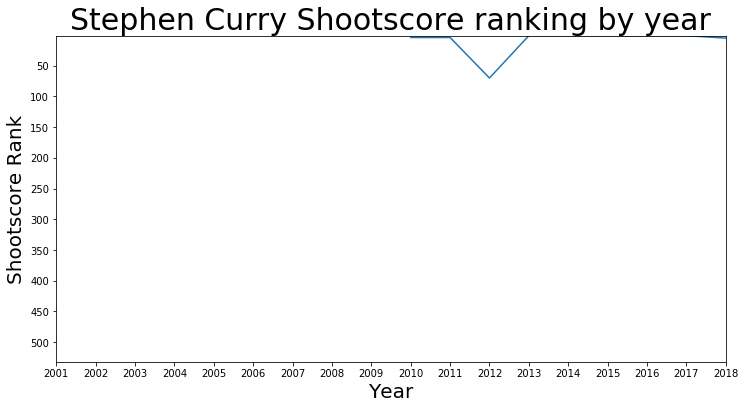

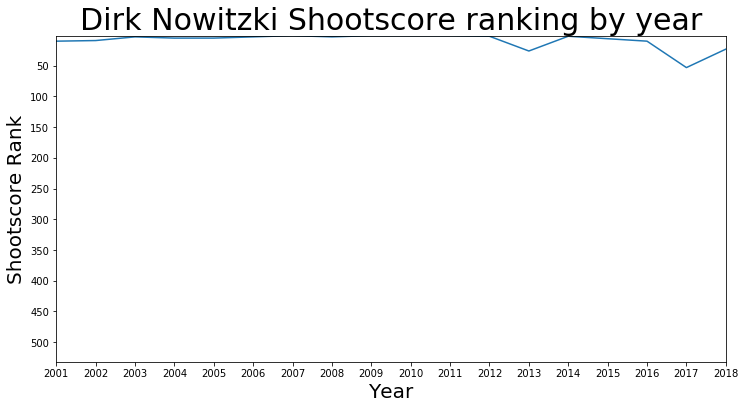

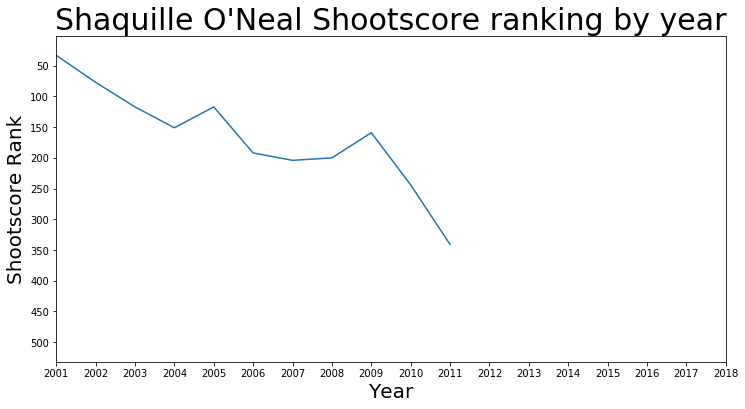

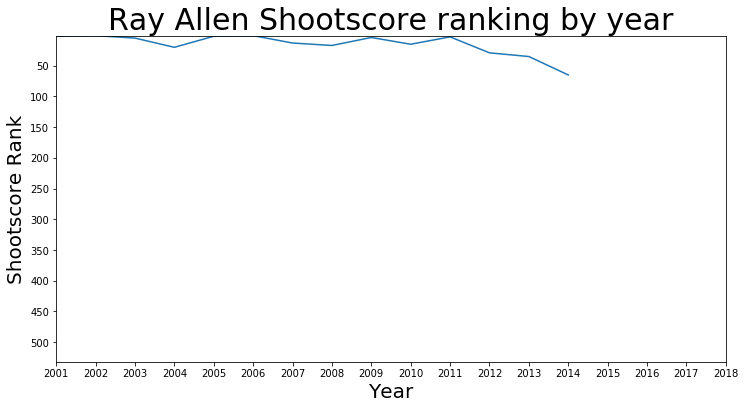

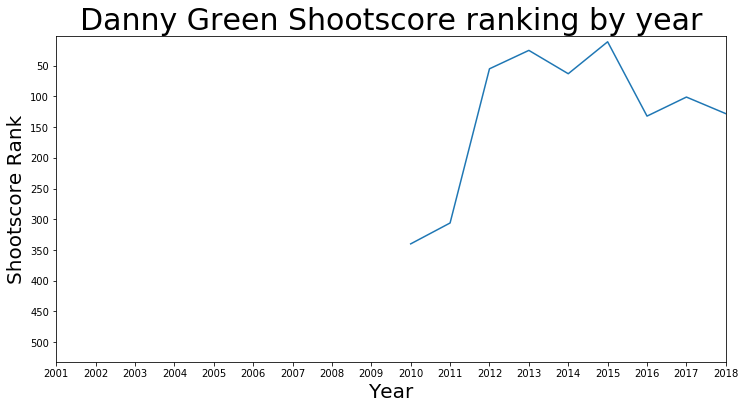

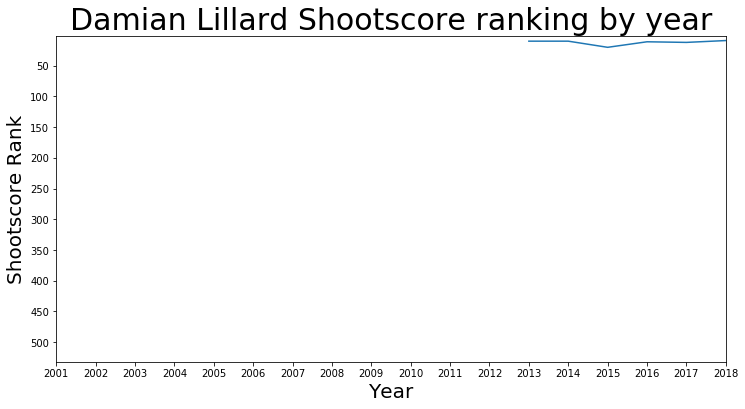

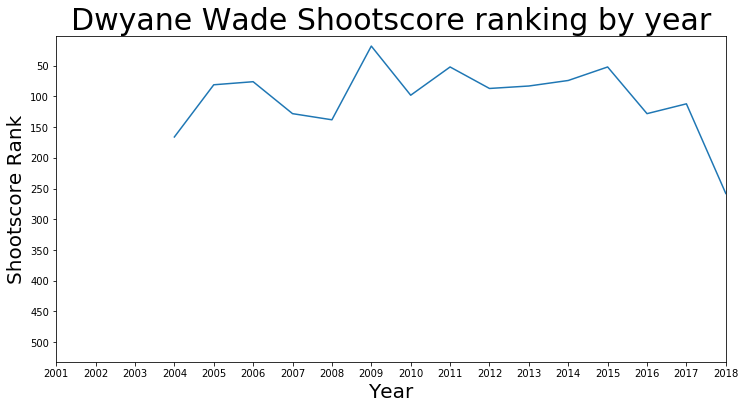

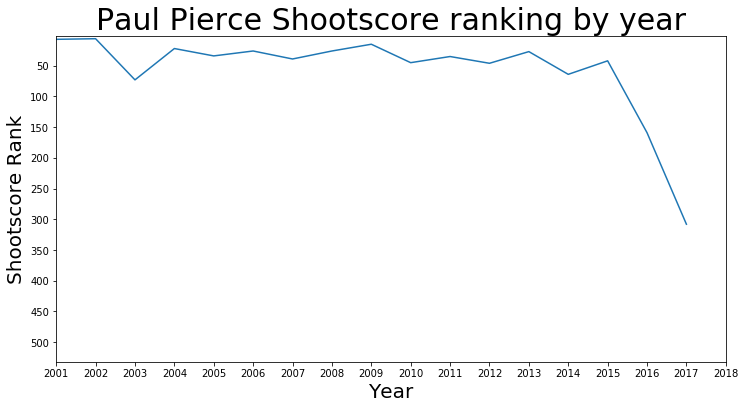

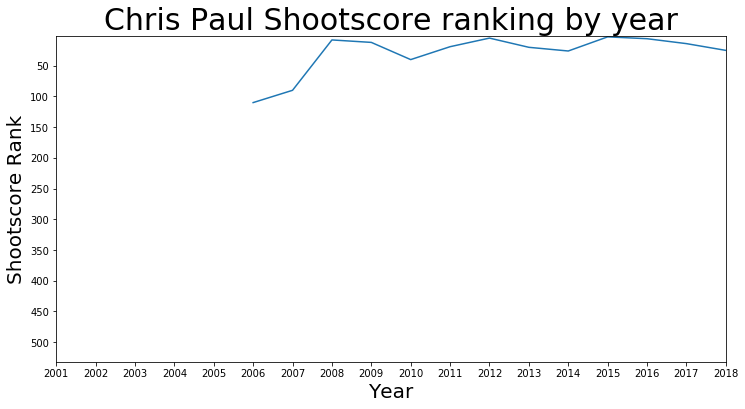

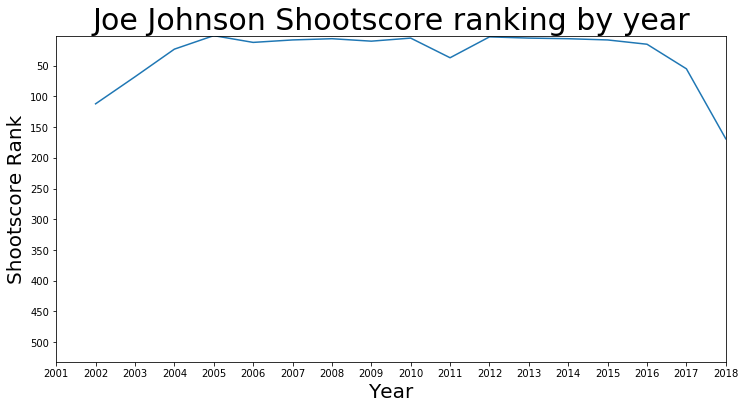

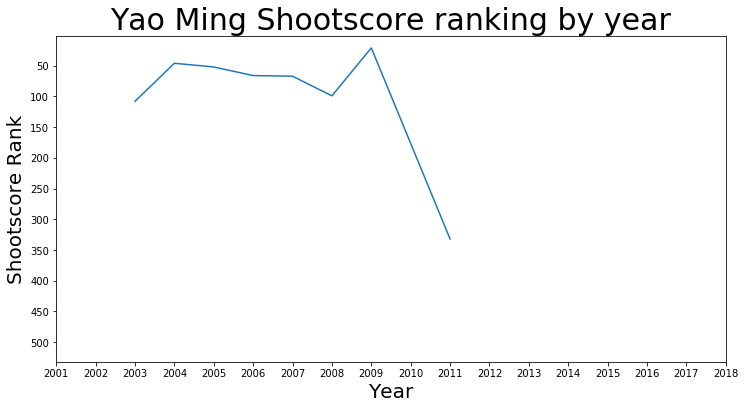

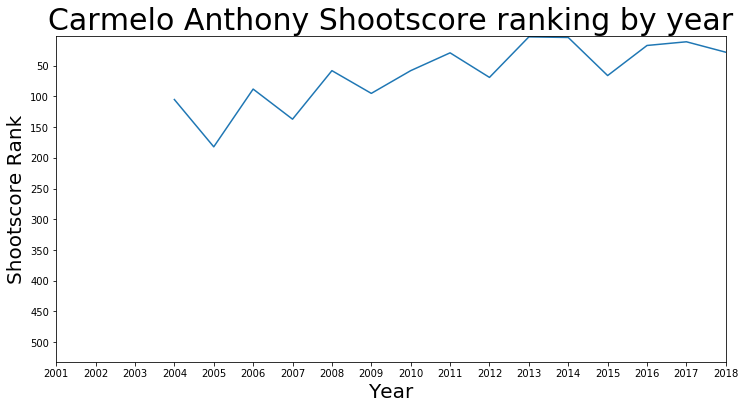

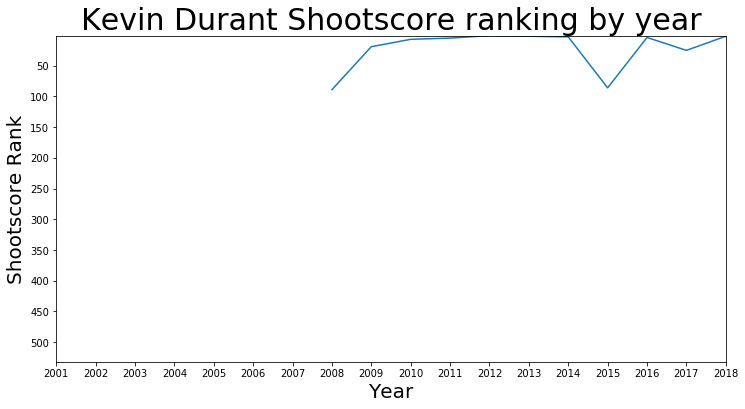

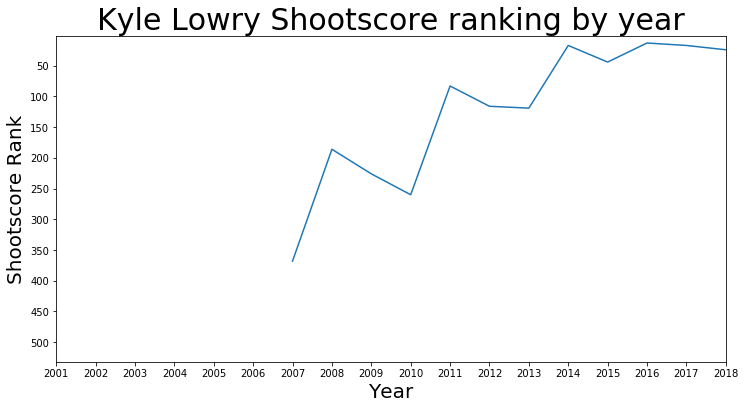

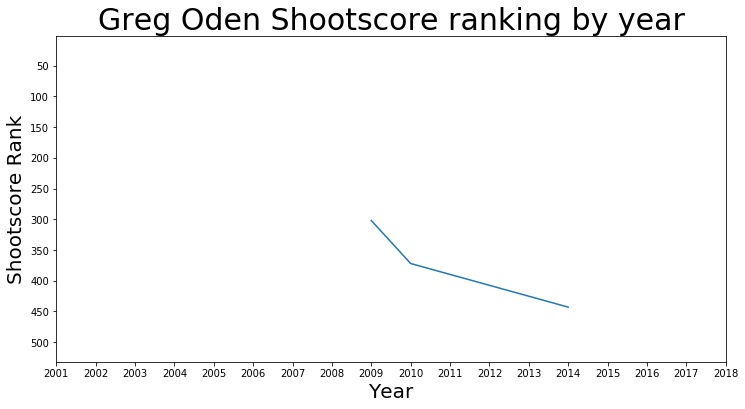

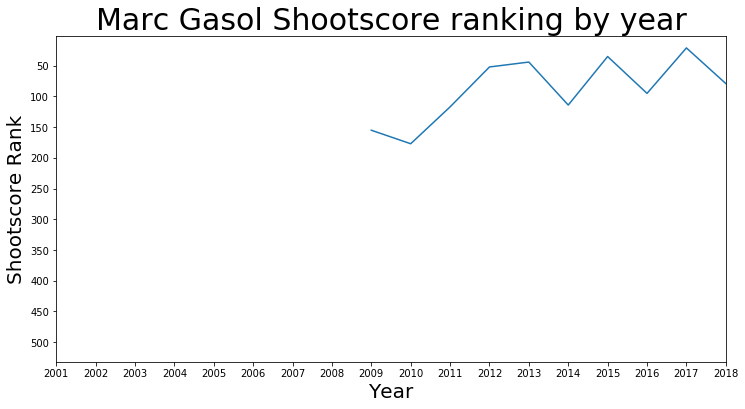

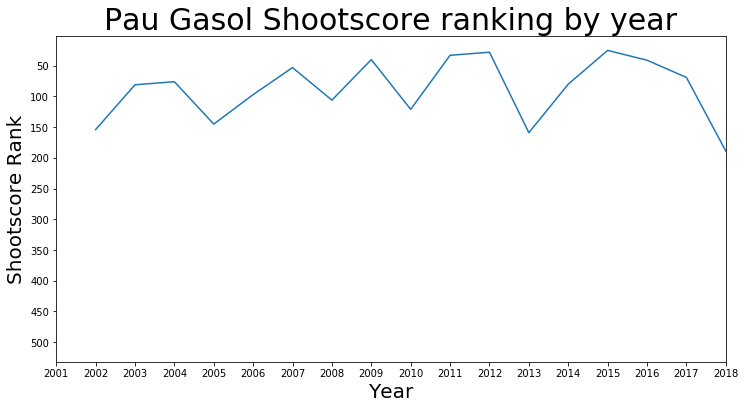

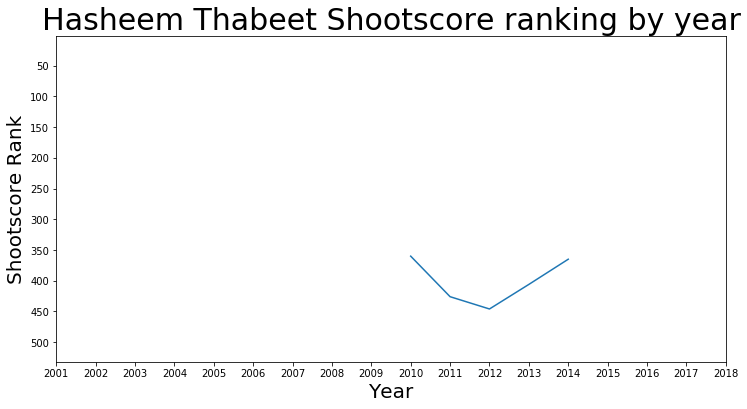

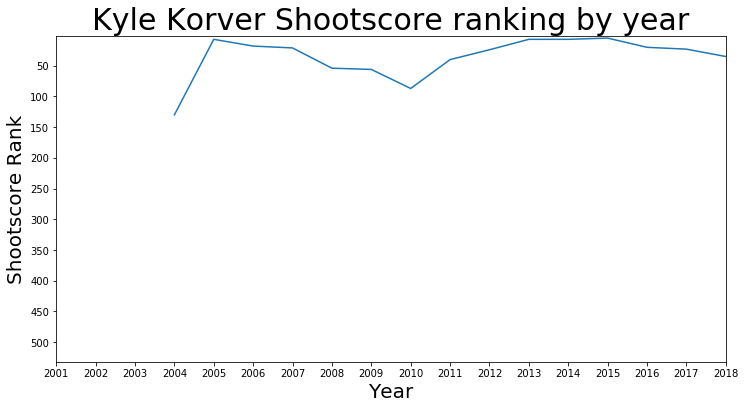

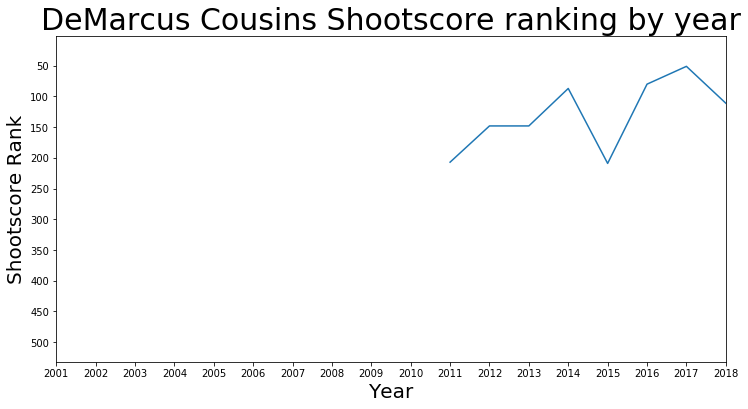

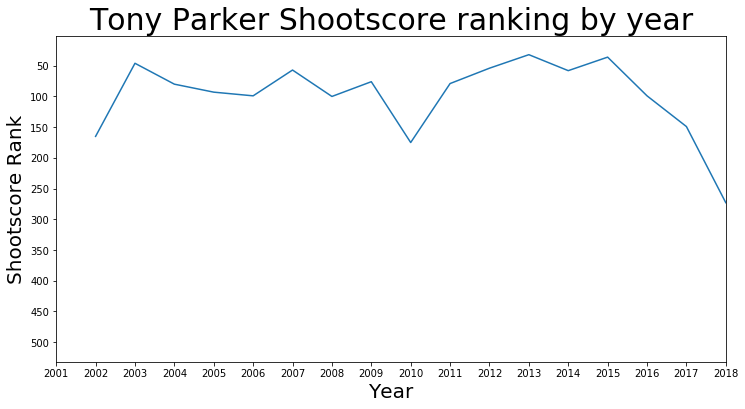

In [51]:
output_names_shootscore_ranks = ["Russell Westbrook",
"James Harden",
"LeBron James",
"Stephen Curry",
"Dirk Nowitzki",
"Shaquille O\'Neal",
"Ray Allen",
"Danny Green",
"Damian Lillard",
"Dwyane Wade",
"Paul Pierce",
"Chris Paul",
"Joe Johnson",
"Yao Ming",
"Carmelo Anthony",
"Kevin Durant",
"Kyle Lowry",
"Greg Oden",
"Marc Gasol",
"Pau Gasol",
"Hasheem Thabeet",
"Kyle Korver",
"DeMarcus Cousins",
"Tony Parker",]
for name in output_names_shootscore_ranks:
    player_shootscore_ranks_graph(name)
    plt.savefig(name + ".png")

In [90]:
def export_shootscores_all_years():
    for i in range(0, 18):
        dfx = playershootscores_comprehensivelist[i]
        dfx.to_csv(str(i + 2000) + "-" + str(i + 2001) + "shootscores.csv", quoting=csv.QUOTE_ALL, sep = ",")

In [93]:
export_shootscores_all_years()

In [107]:
playershootscores_comprehensive.sort_values(by=['Shootscore Index'], ascending=True).to_csv("WorstShootscoreIndexSeasons.csv")

In [108]:
playershootscores_comprehensive.groupby(['Player Name']).sum().sort_values(by=['Shootscore Index'], ascending=True).to_csv("WorstShootersEverDefinitive.csv")